:postbox: 원본 코드 및 doheon 님의 설명을 보고 싶으시다면 아래의 링크로 가주시면 됩니다.
- Original code: https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/

#### :books: 특징
- Transformer (인코더-디코더) 구조에서 Transformer(인코더-FC layer)로 설정 (디코더 FC layer로 변했다고 보면 된다.)
- 인코더 값을 바탕으로 한 번에 멀티 스텝을 예측하는 방식
- input window의 attention의 조합으로 output window를 바로 예측할 수 있다는 가정

#### :abcd:`순서`
1. 1차원 벡터를 d_model 차원으로 바꿔준다.
(batch, input_window, 1) => (batch, input_window, d_model)
2. transformer encoder를 통과한다.
(batch, input_window, d_model) => (batch, input_window, d_model)
3. 결과의 d_model차원을 1차원으로 바꿔준다.
(batch, input_window, d_model) => (batch, input_window, 1)
4. 1차원인 부분을 없앤다.
(batch, input_window, 1) => (batch, input_window)
5. input_window차원을 output_window차원으로 바꿔준다.
(batch, input_window) => (batch, output_window)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


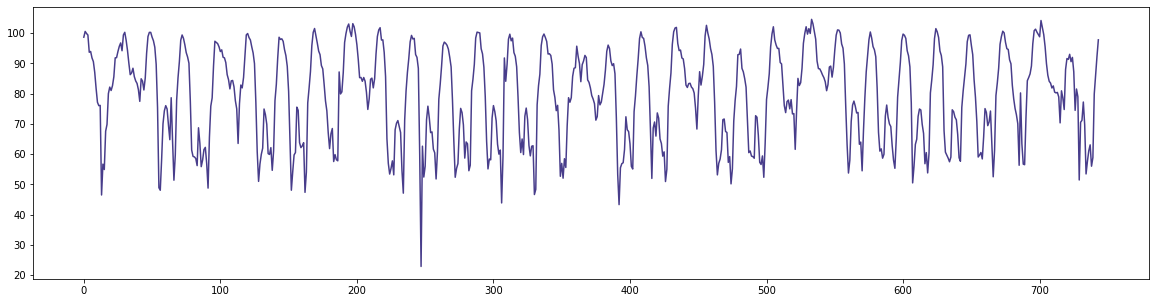

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


In [2]:
rawdata = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata.loc[:,"평균속도"], color = 'darkslateblue')
plt.show()
rawdata.head()

In [3]:
"""Scaling"""
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["평균속도"] = min_max_scaler.fit_transform(rawdata["평균속도"].to_numpy().reshape(-1,1))

In [4]:
"""일주일 간의 데이터를 평가로 사용"""
train = rawdata[:-24*7]
data_train = train["평균속도"].to_numpy()

test = rawdata[-24*7:]
data_test = test["평균속도"].to_numpy()

In [5]:
import torch
import torch.nn as nn
import numpy as np
import math
device = torch.device("cuda")

In [6]:
"""모델 구조"""
## 디코더가 없는 구조이기에 dec_inputs이 따로 필요하지 않다.

from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i] # 디코더에 입력하는 값이 따로 존재하지 않는다.
    def __len__(self):
        return self.len
iw = 24*14

In [7]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64) # batch별로 나누기

In [8]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        # 디코더가 따로 없는 것을 알 수 있다.
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

------
### 모델 뜯어보기

In [9]:
"""mini-batch 하나만 가져오기"""
## Train 시의 모델 입력값
for (inputs, outputs) in train_loader:
    first_inputs = inputs.to(device)
    first_outputs = outputs.to(device)
    break

## 첫 번째 모델 입력값
print('인코더 입력값 :', first_inputs.shape) # [[1],[2],[3],[4],[5]], [[2],[3],[4],[5],[6]]]
print('출력값 :', first_outputs.shape) # [[6], [7]]

인코더 입력값 : torch.Size([64, 336, 1])
출력값 : torch.Size([64, 168, 1])


In [10]:
"""마스킹 설정: generate_square_subsequent_mask()"""
# 하삼각행렬 부분만 남기는 부분
    # 하삼각행렬 성분들은 모두 True로 만들고 나머지는 False
src_mask = (torch.triu(torch.ones(first_inputs.shape[1], first_inputs.shape[1])) == 1).transpose(0, 1).to(device)
print('인코더의 input masking:', src_mask.shape)

# 예시
src_mask

인코더의 input masking: torch.Size([336, 336])


tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0')

In [11]:
## 파라미터 정의 및 모델 설정
d_model = 256
nhead = 8
dropout = 0.2
nlayers=2

self_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout).double().to(device) # self-att와 FFN으로 구성되어 있음
self_transformer_encoder = nn.TransformerEncoder(self_encoder_layer, num_layers=nlayers).double().to(device)
self_pos_encoder = PositionalEncoding(d_model, dropout).double().to(device)

## 인코더 임베딩 레이어
    # 단변량 (1차원) 데이터를 d_model의 차원으로 바꿔준다.
self_encoder = nn.Sequential(
    nn.Linear(1, d_model//2),
    nn.ReLU(),
    nn.Linear(d_model//2, d_model)
).double().to(device)

self_linear =  nn.Sequential(
    nn.Linear(d_model, d_model//2),
    nn.ReLU(),
    nn.Linear(d_model//2, 1)
).double().to(device)

self_linear2 = nn.Sequential(
    nn.Linear(iw, (iw+ow)//2),
    nn.ReLU(),
    nn.Linear((iw+ow)//2, ow)
).double().to(device)


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [12]:
first_inputs.shape

torch.Size([64, 336, 1])

In [13]:
src = self_encoder(first_inputs)
src = self_pos_encoder(src)
print('## 인코더 입력값 shape:', src.shape)

src_mask = generate_square_subsequent_mask(first_inputs.shape[1]).to(device)

## 인코더 입력값 shape: torch.Size([64, 336, 256])


In [14]:
output = self_transformer_encoder(src.transpose(0,1), src_mask).transpose(0,1) # 입력시에는 batch를 중간으로 가게 했다고 출력 후에는 다시 앞으로 오게 하기
print('## 트랜스포머 인코더 output shape:', output.shape)

## 트랜스포머 인코더 output shape: torch.Size([64, 336, 256])


In [15]:
"""디코더 부분의 첫 번째 output"""
output = self_linear(output)
print(output.shape)
print('# 첫번째 linear의 출력 shape: ', output[:,:,0].shape) # output.squeeze(2)와 같음 -> 마지막 차원 제거
output = output[:,:,0]

torch.Size([64, 336, 1])
# 첫번째 linear의 출력 shape:  torch.Size([64, 336])


In [19]:
"""디코더 부분의 두 번째 output"""
## 트랜스포머 인코더를 거친 336의 값들을 output 길이인 168로 변환
output = self_linear2(output)
print('최종 linear output shape:', output.shape)

최종 linear output shape: torch.Size([64, 168])


----
## 모델 실행

In [9]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(iw = 24*7*2, ow = 24*7, d_model = 512, nhead = 8, nlayers = 4, dropout = 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
from tqdm import tqdm
epoch = 1000

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device) # 마스킹 shape 만들기
        result = model(inputs.float().to(device),  src_mask) # 입력값과 마스킹 shape 넣어주기
        loss = criterion(result, outputs[:,:,0].float().to(device)) # loss 계산
        loss.backward() # 역전파
        optimizer.step() # 파라미터 업데이트
        batchloss += loss # batch loss 계산
    if i%100 ==0:
        print(f'## {i}', loss)
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.538958:   0%|          | 1/1000 [00:01<17:34,  1.06s/it]

## 0 tensor(0.5595, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.028687:  10%|█         | 101/1000 [00:44<06:23,  2.34it/s]

## 100 tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.028621:  20%|██        | 201/1000 [01:27<05:43,  2.33it/s]

## 200 tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.020103:  30%|███       | 301/1000 [02:11<05:02,  2.31it/s]

## 300 tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.009849:  40%|████      | 401/1000 [02:54<04:19,  2.31it/s]

## 400 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.006466:  50%|█████     | 501/1000 [03:38<03:35,  2.31it/s]

## 500 tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.004396:  60%|██████    | 601/1000 [04:22<02:52,  2.32it/s]

## 600 tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.003330:  70%|███████   | 701/1000 [05:05<02:09,  2.31it/s]

## 700 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.002693:  80%|████████  | 801/1000 [05:49<01:26,  2.29it/s]

## 800 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.002296:  90%|█████████ | 901/1000 [06:33<00:43,  2.26it/s]

## 900 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


loss: 0.001976: 100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


In [11]:
def evaluate():
    input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

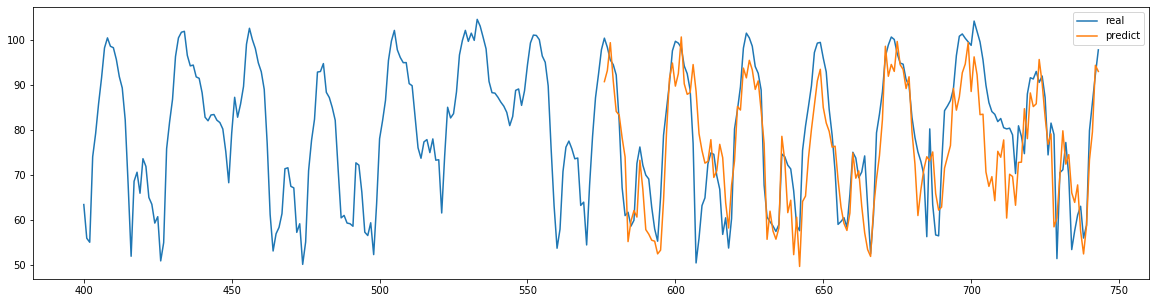

In [12]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["평균속도"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(range(400,744),real[400:], label="real")
plt.plot(range(744-24*7,744),result, label="predict")
plt.legend()
plt.show()

In [13]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

9.555978091545727

In [14]:
torch.save(model.state_dict(), "Multi_step_Transformer.pth")